In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'star-wars/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [3]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


In [5]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#    rotation_range=20,
#    horizontal_flip=True,
#    width_shift_range=0.2, height_shift_range=0.2,
#    shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'star-wars/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'star-wars/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'star-wars/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [6]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 4. 3. 4.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


In [7]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

In [8]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)               

In [9]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [10]:
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=2)

Epoch 1/30



10/10 - 2s - loss: 11.2260 - accuracy: 0.2973 - val_loss: 2.0168 - val_accuracy: 0.2500 - 2s/epoch - 234ms/step
Epoch 2/30
10/10 - 1s - loss: 1.7485 - accuracy: 0.2432 - val_loss: 1.7952 - val_accuracy: 0.1875 - 883ms/epoch - 88ms/step
Epoch 3/30
10/10 - 1s - loss: 1.6281 - accuracy: 0.2432 - val_loss: 1.5705 - val_accuracy: 0.2500 - 886ms/epoch - 89ms/step
Epoch 4/30
10/10 - 1s - loss: 1.5351 - accuracy: 0.4054 - val_loss: 1.5253 - val_accuracy: 0.5000 - 918ms/epoch - 92ms/step
Epoch 5/30
10/10 - 1s - loss: 1.3712 - accuracy: 0.5946 - val_loss: 1.4582 - val_accuracy: 0.3750 - 871ms/epoch - 87ms/step
Epoch 6/30
10/10 - 1s - loss: 0.9994 - accuracy: 0.7027 - val_loss: 1.2143 - val_accuracy: 0.6875 - 902ms/epoch - 90ms/step
Epoch 7/30
10/10 - 1s - loss: 0.7076 - accuracy: 0.7297 - val_loss: 1.2480 - val_accuracy: 0.6250 - 892ms/epoch - 89ms/step
Epoch 8/30
10/10 - 1s - loss: 0.3032 - accuracy: 0.9189 - val_loss: 3.1540 - val_accuracy: 0.4375 - 899ms/epoch - 90ms/step
Epoch 9/30
10/10 - 1

In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [12]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 0.2356 - accuracy: 0.8000 - 157ms/epoch - 52ms/step


[0.23561803996562958, 0.800000011920929]

In [13]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 0s 16ms/step
[0. 0. 1. 1.]
[1 0 1 0]


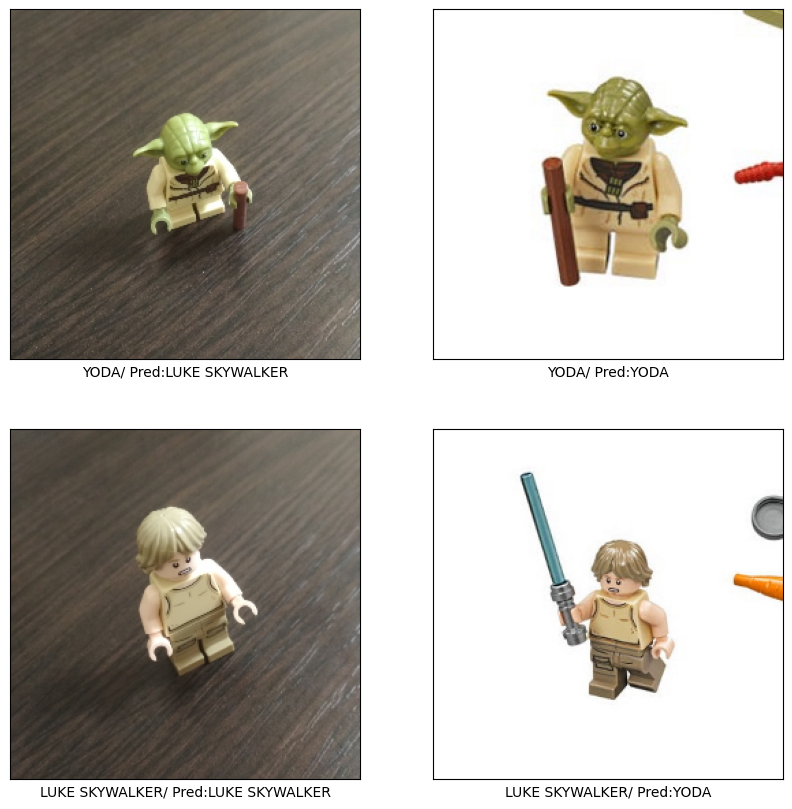

In [14]:
show(test_batches[0], labels[0:4])

In [15]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'keras.src.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool

In [16]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [18]:
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [19]:
model.add(layers.Dense(5))

In [20]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [21]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [23]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'star-wars/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'star-wars/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'star-wars/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [24]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 4s - loss: 2.1905 - accuracy: 0.3243 - val_loss: 0.6211 - val_accuracy: 0.6875 - 4s/epoch - 438ms/step
Epoch 2/30
10/10 - 3s - loss: 0.6463 - accuracy: 0.7297 - val_loss: 0.4477 - val_accuracy: 0.8125 - 3s/epoch - 347ms/step
Epoch 3/30
10/10 - 3s - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.5896 - val_accuracy: 0.7500 - 3s/epoch - 344ms/step
Epoch 4/30
10/10 - 3s - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.7027 - val_accuracy: 0.7500 - 3s/epoch - 340ms/step
Epoch 5/30
10/10 - 3s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.5948 - val_accuracy: 0.7500 - 3s/epoch - 339ms/step
Epoch 6/30
10/10 - 3s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4765 - val_accuracy: 0.7500 - 3s/epoch - 342ms/step
Epoch 7/30
10/10 - 3s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4049 - val_accuracy: 0.8125 - 3s/epoch - 342ms/step
Epoch 8/30
10/10 - 3s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.8750 - 3s/epoch - 345ms/step
Epoch 9/30
10/10 - 3s - 

In [25]:
model.evaluate(test_batches, verbose=2)

3/3 - 1s - loss: 0.2015 - accuracy: 0.9000 - 684ms/epoch - 228ms/step


[0.20151379704475403, 0.8999999761581421]

In [29]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet()
print(type(vgg_model))
mobilenet_model.summary()

17225924/17225924 [==============================] - 2s 0us/step
<class 'keras.src.engine.functional.Functional'>
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               


 conv_pw_7_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_8 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8

In [30]:
model = keras.models.Sequential()
for layer in mobilenet_model.layers[0:-1]:
    model.add(layer)

In [31]:
model.add(layers.Dense(5))

In [32]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [34]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [35]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'star-wars/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'star-wars/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'star-wars/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [36]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 8s - loss: 10.3830 - accuracy: 0.2973 - val_loss: 43.8098 - val_accuracy: 0.1875 - 8s/epoch - 792ms/step
Epoch 2/30
10/10 - 1s - loss: 3.4258 - accuracy: 0.6486 - val_loss: 12.6173 - val_accuracy: 0.3125 - 1s/epoch - 106ms/step
Epoch 3/30
10/10 - 1s - loss: 3.8745 - accuracy: 0.7838 - val_loss: 15.2581 - val_accuracy: 0.5000 - 1s/epoch - 101ms/step
Epoch 4/30
10/10 - 1s - loss: 2.7193 - accuracy: 0.7568 - val_loss: 6.6875 - val_accuracy: 0.6250 - 1s/epoch - 104ms/step
Epoch 5/30
10/10 - 1s - loss: 4.5219 - accuracy: 0.7568 - val_loss: 18.6637 - val_accuracy: 0.4375 - 1s/epoch - 102ms/step
Epoch 6/30
10/10 - 1s - loss: 3.4045 - accuracy: 0.6486 - val_loss: 8.7851 - val_accuracy: 0.4375 - 1s/epoch - 101ms/step
Epoch 7/30
10/10 - 1s - loss: 2.8931 - accuracy: 0.8108 - val_loss: 2.5724 - val_accuracy: 0.8750 - 1s/epoch - 111ms/step
Epoch 8/30
10/10 - 1s - loss: 1.7771 - accuracy: 0.8649 - val_loss: 5.8804 - val_accuracy: 0.6875 - 1s/epoch - 116ms/step
Epoch 9/30
10/10 - 

In [37]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 25.6854 - accuracy: 0.6000 - 164ms/epoch - 55ms/step


[25.685428619384766, 0.6000000238418579]

In [49]:
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=5,
    classifier_activation='softmax')
print(type(vgg_model))
vgg19_model.summary()

<class 'keras.src.engine.functional.Functional'>
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool

In [55]:
model = keras.models.Sequential()
for layer in vgg19_model.layers:
    model.add(layer)

In [56]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [57]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [58]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'star-wars/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'star-wars/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'star-wars/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [59]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30


C:\Users\udith\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 - 16s - loss: 1.6288 - accuracy: 0.1081 - val_loss: 1.6109 - val_accuracy: 0.1875 - 16s/epoch - 2s/step
Epoch 2/30
10/10 - 13s - loss: 1.6209 - accuracy: 0.1892 - val_loss: 1.6096 - val_accuracy: 0.1875 - 13s/epoch - 1s/step
Epoch 3/30
10/10 - 13s - loss: 1.6152 - accuracy: 0.1081 - val_loss: 1.6082 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 4/30
10/10 - 13s - loss: 1.6140 - accuracy: 0.2162 - val_loss: 1.6078 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 5/30
10/10 - 13s - loss: 1.6101 - accuracy: 0.2162 - val_loss: 1.6071 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 6/30
10/10 - 13s - loss: 1.6092 - accuracy: 0.2162 - val_loss: 1.6075 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 7/30
10/10 - 13s - loss: 1.6098 - accuracy: 0.2162 - val_loss: 1.6071 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 8/30
10/10 - 13s - loss: 1.6091 - accuracy: 0.2162 - val_loss: 1.6068 - val_accuracy: 0.2500 - 13s/epoch - 1s/step
Epoch 9/30
10/10 - 13s - loss: 1.6108 - acc